In [1]:
# import the necessary packages
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)


In [2]:
#loading the data as traindata and test data 
#The compose function allows for multiple transforms
#transforms.ToTensor() converts our PILImage to a tensor of shape (C x H x W) in the range [0,1]
#transforms.Normalize(mean,std) normalizes a tensor to a (mean, std) for (R, G, B)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = torchvision.datasets.ImageFolder('C:/Users/Mayank/Downloads/trainimages',transform=transform)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=4,shuffle=True, num_workers=2)
test_set = torchvision.datasets.ImageFolder('C:/Users/Mayank/Downloads/testimagess',transform=transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=4,shuffle=True, num_workers=2)

In [3]:
#different classes for classification
classes=('CEREAL','CHOCOLATE','COFFEE','HONEY','JAM','JUICE','NUTS','SPICES','TOMATO_SAUCE','PASTA')

In [4]:
from torch.utils.data.sampler import SubsetRandomSampler

#Training
n_training_samples = 2000
train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))

#Validation
n_val_samples = 100
val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples + n_val_samples, dtype=np.int64))

#Test
n_test_samples = 800
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))

In [5]:
from torch.autograd import Variable
import torch.nn.functional as F

class SimpleCNN(torch.nn.Module):
    
    #Our batch shape for input x is (3, 256, 256)
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        #Input channels = 3, output channels = 18
        self.conv1 = torch.nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        #294912 input features, 64 output features (see sizing flow below)
        self.fc1 = torch.nn.Linear(18 * 128 * 128, 128)
        
        #64 input features, 10 output features for our 10 defined classes
        self.fc2 = torch.nn.Linear(128, 10)
        
    def forward(self, x):
        
        #Computes the activation of the first convolution
        #Size changes from (3, 256, 256) to (18, 256, 256)
        x = F.relu(self.conv1(x))
        
        #Size changes from (18, 256, 256) to (18, 128, 128)
        x = self.pool(x)
        
        #Reshape data to input to the input layer of the neural net
        #Size changes from (18, 128, 128) to (1, 29412)
        #Recall that the -1 infers this dimension from the other given dimension
        x = x.view(-1, 18 * 128 *128)
        
        #Computes the activation of the first fully connected layer
        #Size changes from (1, 29412) to (1, 64)
        x = F.relu(self.fc1(x))
        
        #Computes the second fully connected layer (activation applied later)
        #Size changes from (1, 64) to (1, 10)
        x = self.fc2(x)
        return(x)

In [6]:
def outputSize(in_size, kernel_size, stride, padding):

    output = int((in_size - kernel_size + 2*(padding)) / stride) + 1

    return(output)

In [7]:
#DataLoader takes in a dataset and a sampler for loading (num_workers deals with system level memory) 
def get_train_loader(batch_size):
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                           sampler=train_sampler, num_workers=2)
    return(train_loader)

In [8]:
#Test loader have constant batch sizes, so we can define them directly
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4, sampler=test_sampler, num_workers=2)
val_loader = torch.utils.data.DataLoader(train_set, batch_size=128, sampler=val_sampler, num_workers=2)

In [9]:
#loss and optimizer function
import torch.optim as optim

def createLossAndOptimizer(net, learning_rate=0.001):
    
    #Loss function
    loss = torch.nn.CrossEntropyLoss()
    
    #Optimizer
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    
    return(loss, optimizer)

In [10]:
import time

def trainNet(net, batch_size, n_epochs, learning_rate):
    
    #Print all of the hyperparameters of the training iteration:
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    #Get training data
    train_loader = get_train_loader(batch_size)
    n_batches = len(train_loader)
    
    #Create our loss and optimizer functions
    loss, optimizer = createLossAndOptimizer(net, learning_rate)
    
    #Time for printing
    training_start_time = time.time()
    
    #Loop for n_epochs
    for epoch in range(n_epochs):
        
        running_loss = 0.0
        print_every = n_batches // 10
        start_time = time.time()
        total_train_loss = 0
        
        for i, data in enumerate(train_loader, 0):
            
            #Get inputs
            inputs, labels = data
            
            #Wrap them in a Variable object
            inputs, labels = Variable(inputs), Variable(labels)
            
            #Set the parameter gradients to zero
            optimizer.zero_grad()
            
            #Forward pass, backward pass, optimize
            outputs = net(inputs)
            loss_size = loss(outputs, labels)
            loss_size.backward()
            optimizer.step()
            
            #Print statistics
            running_loss += loss_size.data[0]
            total_train_loss += loss_size.data[0]
            
            #Print every 10th batch of an epoch
            if (i + 1) % (print_every + 1) == 0:
                print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                        epoch+1, int(100 * (i+1) / n_batches), running_loss / print_every, time.time() - start_time))
                #Reset running loss and time
                running_loss = 0.0
                start_time = time.time()
            
        #At the end of the epoch, do a pass on the validation set
        total_val_loss = 0
        for inputs, labels in val_loader:
            
            #Wrap tensors in Variables
            inputs, labels = Variable(inputs), Variable(labels)
            
            #Forward pass
            val_outputs = net(inputs)
            val_loss_size = loss(val_outputs, labels)
            total_val_loss += val_loss_size.data[0]
            
        print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))
        
    print("Training finished, took {:.2f}s".format(time.time() - training_start_time))

In [11]:
CNN = SimpleCNN()
trainNet(CNN, batch_size=32, n_epochs=5, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 32
epochs= 5
learning_rate= 0.001


C:\Users\Mayank\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
C:\Users\Mayank\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 1, 11% 	 train_loss: 35.74 took: 19.90s
Epoch 1, 22% 	 train_loss: 11.53 took: 15.46s
Epoch 1, 33% 	 train_loss: 5.94 took: 15.49s
Epoch 1, 44% 	 train_loss: 3.28 took: 15.35s
Epoch 1, 55% 	 train_loss: 2.59 took: 15.69s
Epoch 1, 66% 	 train_loss: 2.62 took: 15.19s
Epoch 1, 77% 	 train_loss: 2.60 took: 15.84s
Epoch 1, 88% 	 train_loss: 2.64 took: 15.25s
Epoch 1, 100% 	 train_loss: 2.64 took: 14.12s


C:\Users\Mayank\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation loss = 2.55
Epoch 2, 11% 	 train_loss: 2.55 took: 18.39s
Epoch 2, 22% 	 train_loss: 2.56 took: 15.41s
Epoch 2, 33% 	 train_loss: 2.56 took: 15.74s
Epoch 2, 44% 	 train_loss: 2.51 took: 15.56s
Epoch 2, 55% 	 train_loss: 2.66 took: 15.29s
Epoch 2, 66% 	 train_loss: 2.59 took: 15.65s
Epoch 2, 77% 	 train_loss: 2.57 took: 18.29s
Epoch 2, 88% 	 train_loss: 2.58 took: 17.49s
Epoch 2, 100% 	 train_loss: 2.47 took: 16.07s
Validation loss = 2.85
Epoch 3, 11% 	 train_loss: 2.42 took: 29.27s
Epoch 3, 22% 	 train_loss: 2.35 took: 16.86s
Epoch 3, 33% 	 train_loss: 2.47 took: 17.36s
Epoch 3, 44% 	 train_loss: 2.44 took: 17.62s
Epoch 3, 55% 	 train_loss: 2.43 took: 17.72s
Epoch 3, 66% 	 train_loss: 2.36 took: 17.55s
Epoch 3, 77% 	 train_loss: 2.45 took: 17.47s
Epoch 3, 88% 	 train_loss: 2.46 took: 17.66s
Epoch 3, 100% 	 train_loss: 2.44 took: 16.36s
Validation loss = 2.76
Epoch 4, 11% 	 train_loss: 2.41 took: 21.82s
Epoch 4, 22% 	 train_loss: 2.33 took: 15.73s
Epoch 4, 33% 	 train_loss: 2.

JUICE HONEY JUICE CHOCOLATE


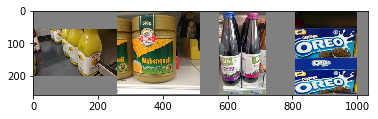

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

GroundTruth:  TOMATO_SAUCE PASTA PASTA TOMATO_SAUCE


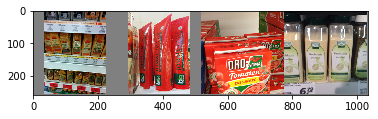

In [17]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [18]:
outputss=CNN(images)

In [19]:
_, predicted = torch.max(outputss, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  CEREAL COFFEE CEREAL CEREAL


In [20]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = CNN(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 20 %


In [21]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = CNN(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(3):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of CEREAL : 60 %
Accuracy of CHOCOLATE : 68 %
Accuracy of COFFEE : 20 %
Accuracy of HONEY :  0 %
Accuracy of   JAM : 66 %
Accuracy of JUICE :  0 %
Accuracy of  NUTS : 16 %
Accuracy of SPICES :  0 %
Accuracy of TOMATO_SAUCE :  0 %
Accuracy of PASTA :  0 %
